In [1]:
import pandas as pd
import numpy as np
from scipy.stats import t
from scipy.optimize import minimize 
import yfinance as yf
import seaborn as sns

In [2]:
def return_calculate(prices, method="DISCRETE"):
    dates = prices.Date[1:]
    ar = prices["INTC"].pct_change(1)[1:]
    lr = np.log(1 + ar)
    rtn = pd.DataFrame({"Date": dates, "Arithmetic Return": ar, "Log Return": lr})
    if method == "DISCRETE":
        return rtn[["Date", "Arithmetic Return"]]
    elif method == "LOG":
        return rtn[["Date", "Log Return"]]
    else:
        raise Exception("?")

In [3]:
prices = pd.read_csv("DailyPrices.csv")

In [4]:
intc = return_calculate(prices)
intc_mean = intc["Arithmetic Return"].mean()

In [5]:
intc_demean = intc["Arithmetic Return"] - intc_mean

In [6]:
# normal dist from here
std = np.std(intc_demean)
var_n = 1.65 * std

In [7]:
# exp normal dist
λ = 0.94
weights = [(1-λ)*λ**(i-1) for i in range(1, len(intc_demean.index)+1) ]
weights = [weight/sum(weights) for weight in weights]
variance = sum(weights * intc_demean**2)
std_exp = variance**(1/2)
var_exp = 1.65 * std_exp

In [8]:
var_exp

0.05072918921533632

In [9]:
# MLE
def MLE_t(parameters):
    # extract parameters
    df, std = parameters
    # Calculate the log-likelihood for normal distribution
    LL = np.sum(t.logpdf(df, std))
#     mean, var, skew, kurt = t.stats(df, moments='mvsk')

    # Calculate the negative log-likelihood
    neg_LL = -1*LL
    return neg_LL 


In [10]:
mle_model = minimize(MLE_t, np.array([59, std]), method='L-BFGS-B')
mle_model 

      fun: 0.9199654608522359
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.22395444e-03,  2.88657757e-06])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 231
      nit: 41
     njev: 77
   status: 0
  success: True
        x: array([-3.21122772e-03,  2.44677427e+02])

In [11]:
# cited from: https://github.com/BSIC/VaR/blob/master/VaR.py
# Historical var
def VaR(Returns, Confidence_Interval = 0.95 , Period_Interval = None ,
        Series = False ,removeNa = True):    
    if removeNa==True: Returns = Returns[pd.notnull(Returns)]

    if (Series == True and Period_Interval == None):
        Period_Interval = 100
    elif Period_Interval == None: 
        Period_Interval = len(Returns)
        
    if Series == False:
        Data = Returns[-Period_Interval:]
        Value_at_Risk = -np.percentile(Data,1-Confidence_Interval)
    if Series == True:
        Value_at_Risk = pd.Series(index=Returns.index, name = 'HSVaR')
        for i in range(0,len(Returns)-Period_Interval):
            if i == 0: Data = Returns[-(Period_Interval):]
            else: Data = Returns[-(Period_Interval+i):-i]
            Value_at_Risk[-i-1] = -np.percentile(Data,1-Confidence_Interval)

   
    return(Value_at_Risk)


In [12]:
VaR(intc_demean)

0.11450355388382355

In [13]:
# yahoo finance
hist = yf.Ticker("INTC").history(start="2022-01-14", period="max").Close

In [14]:
hist_return = hist.pct_change(1)[1:]

<AxesSubplot:xlabel='Close', ylabel='Density'>

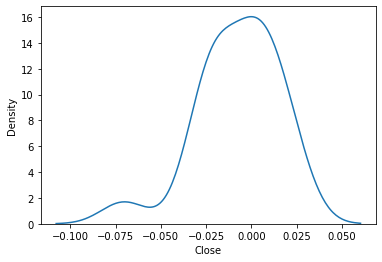

In [15]:
sns.kdeplot(hist_return)